# Ex 9

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.transform import Rotation
from util_functions import (
    PiInv,
    Pi,
    R,
    camera_intrinsic,
    fundamental_matrix,
)

np.random.seed(8)  # for reproducibility

In [77]:
# From week 3 exercise. But I don't think this is needed.
K = camera_intrinsic(1000, (300, 200))
R1 = np.eye(3)
t1 = np.array([[0, 0, 0]]).T
R2 = R(0.7, -0.5, 0.8)
t2 = np.array([[0.2, 2, 1]]).T
R2 = Rotation.from_euler("xyz", [0.7, -0.5, 0.8]).as_matrix()

Ftrue = fundamental_matrix(K, R1, t1, K, R2, t2)
print(f"Ftrue: {Ftrue}")

F_true: [[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


In [76]:
data = np.load("media/Fest_test.npy", allow_pickle=True).item()
q1 = data["q1"]
q2 = data["q2"]
Ftrue_test = data["Ftrue"]
print(f"q1: {q1}")  # (3, 8)
print(f"q2: {q2}")  # (3, 8)
print(f"Ftrue_test: {Ftrue_test}")

q1: [[192.80308677 383.84844629 552.40550165 395.55690526 416.17883753
  366.71606701 649.12832188 437.85457401]
 [482.655306   522.55261707 373.4083753  550.57520093 157.95394133
  379.58268042 141.20188192 571.00584606]
 [  1.           1.           1.           1.           1.
    1.           1.           1.        ]]
q2: [[ 77.42041221 254.60721249 469.08032639 278.08133782 308.0810652
  270.86822192 508.91666875 288.72429284]
 [479.74166846 521.16039433 373.38678026 549.34478578 157.66285399
  378.83939131 138.78418921 569.99677028]
 [  1.           1.           1.           1.           1.
    1.           1.           1.        ]]
Ftrue_test: [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


In [87]:
# Ex 9.1


def Fest_8point(q1, q2):
    """
    Estimate the fundamental matrix using the 8-point linear algorithm.

    Args:
        q1 (np.ndarray): 2D points in image 1, shape (2, 8).
        q2 (np.ndarray): 2D points in image 2, shape (2, 8).

    Returns:
        F (np.ndarray): The estimated fundamental matrix, shape (3, 3).
    """
    # Construct B vector
    B = np.zeros((q1.shape[1], 9))
    for i in range(q1.shape[1]):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array([x1 * x2, y1 * x2, x2, x1 * y2, y1 * y2, y2, x1, y1, 1])
        B[i] = Bi

    # Solve for F
    U, S, V = np.linalg.svd(B)
    F = V[-1].reshape(3, 3)

    return F


Ftrue_normalized = Ftrue / Ftrue[-1, -1]
print(f"Ftrue: {Ftrue}")
print(f"Ftrue_normalized: {Ftrue_normalized}")

q1, q2 = Pi(q1), Pi(q2)  # (3,8) -> (2,8)
F_est = Fest_8point(q1, q2)
print(f"\nF_est: {F_est}")
print(f"F_est norm: {F_est / F_est[-1, -1]}")

Ftrue: [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
Ftrue_normalized: [[-3.15078002e-08  3.70302696e-06 -5.56229877e-04]
 [ 4.60342794e-06  2.29623299e-08 -1.55045161e-01]
 [-1.99765169e-03  1.51745612e-01  1.00000000e+00]]

F_est: [[-3.07914555e-08  3.61883689e-06 -5.43583727e-04]
 [ 4.49876682e-06  2.24402705e-08 -1.51520136e-01]
 [-1.95223414e-03  1.48295604e-01  9.77264527e-01]]
F_est norm: [[-3.15078003e-08  3.70302696e-06 -5.56229876e-04]
 [ 4.60342794e-06  2.29623299e-08 -1.55045161e-01]
 [-1.99765169e-03  1.51745612e-01  1.00000000e+00]]


In [6]:
# Ex 9.2
data = np.load("media/TwoImageData.npy", allow_pickle=True).item()
print(data.keys())
im1 = data["im1"]
im2 = data["im2"]
R1 = data["R1"]
t1 = data["t1"]
R2 = data["R2"]
t2 = data["t2"]
K = data["K"]

dict_keys(['im1', 'im2', 'R1', 'R2', 't1', 't2', 'K'])


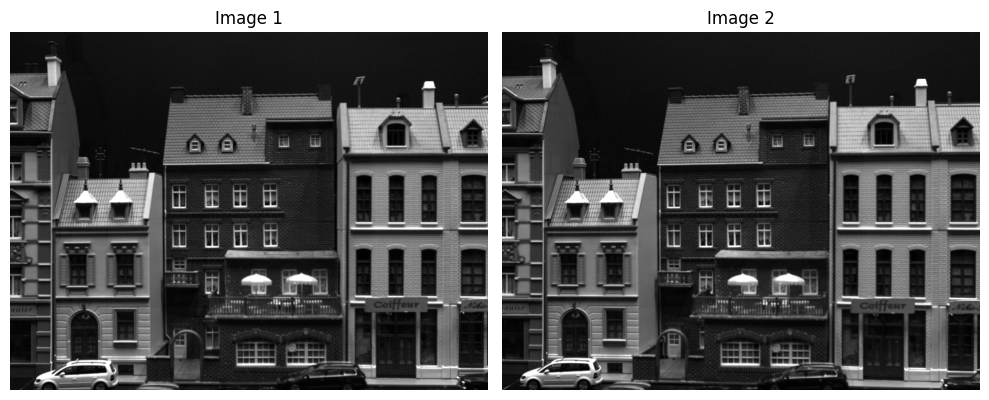

In [88]:
# Plot raw images for reference
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im1, cmap="gray")
axs[0].axis("off")
axs[0].set_title("im1")
axs[1].imshow(im2, cmap="gray")
axs[1].axis("off")
axs[1].set_title("im2")
plt.tight_layout()
plt.show()

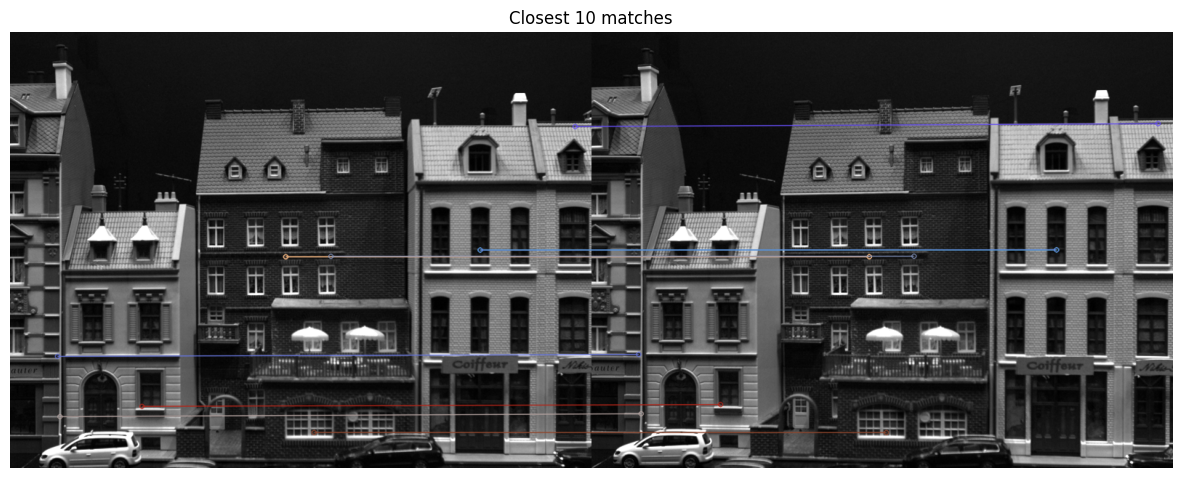

Number of matches: 2086


In [72]:
def find_features(im1, im2, plot=False):
    """
    Find matching features between two images.

    Args:
        im1 (np.ndarray): The first image.
        im2 (np.ndarray): The second image.

    Returns:
        matches (list): Matching features (cv2.DMatch objects).
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
    """
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # ascending

    # Draw first 10 matches.
    if plot:
        img3 = cv2.drawMatches(
            im1,
            kp1,
            im2,
            kp2,
            matches[:10],
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        mpl.rcParams["figure.figsize"] = [15, 10]
        plt.imshow(img3)
        plt.axis("off")
        plt.title("Closest 10 matches")
        plt.show()
        mpl.rcParams["figure.figsize"] = [8, 6]

    return matches, kp1, kp2


# Feature matching is correct when the connecting lines are mostly parallel.
matches, kp1, kp2 = find_features(im1, im2, plot=True)
print(f"Number of matches: {len(matches)}")

In [62]:
def sampsons_distance(F, p1, p2):
    """
    Compute the Sampson distance for the given fundamental matrix and point correspondences.

    Args:
        F (np.array): The fundamental matrix, shape (3, 3).
        p1 (np.array): 2D points in image 1, shape (2, N).
        p2 (np.array): 2D points in image 2, shape (2, N).

    Returns:
        dist (np.array): The Sampson distance for each point, shape (N,).
    """
    # if p1.shape[0] == 3 and p2.shape[0] == 3:
    #     # Normalize points
    #     p1 = p1[:2] / p1[2]
    #     p2 = p2[:2] / p2[2]
    # if p1.shape[0] != 2 or p2.shape[0] != 2:
    #     raise ValueError("p1 and p2 must have shape (2, N).")

    # Make homogeneous to multiply with F
    p1 = PiInv(p1)
    p2 = PiInv(p2)
    distances = np.zeros((p1.shape[1], 1))

    # For each pair of points
    for i in range(p1.shape[1]):
        p1i, p2i = p1[:, i], p2[:, i]
        num = (p2i.T @ F @ p1i) ** 2
        denom = (
            (p2i.T @ F[0]) ** 2
            + (p2i.T @ F[1]) ** 2
            + (F @ p1i)[0] ** 2
            + (F @ p1i)[1] ** 2
        )
        dist = num / denom
        distances[i, :] = dist
    return distances

In [92]:
# One iteration of RANSAC

# Find matches and prepare samples
matches, kp1, kp2 = find_features(im1, im2, plot=False)
match_samples = np.random.choice(matches, 8, replace=False)
im1_matches = np.array(
    [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1]) for m in matches]
)  # (N, 2)
im2_matches = np.array(
    [(kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in matches]
)  # (N, 2)

# Extract coordinates
matched_points = np.array(
    [
        (
            kp1[m.queryIdx].pt[0],
            kp1[m.queryIdx].pt[1],
            kp2[m.trainIdx].pt[0],
            kp2[m.trainIdx].pt[1],
        )
        for m in match_samples
    ]
)
print(f"matched_points: {matched_points}")
im1_samples = np.array(
    [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1]) for m in match_samples]
)
im2_samples = np.array(
    [(kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in match_samples]
)
print(f"im1_samples: {im1_samples}")
print(f"im2_samples: {im2_samples}")

# RANSAC segment
F = Fest_8point(im1_samples.T, im2_samples.T)
print(f"F_est from 8-point: {F}")
dist_samp = sampsons_distance(F, im1_matches.T, im2_matches.T)

# Inliers
threshold = 3.84 * 3**2
inliers = [idx for idx, dist in enumerate(dist_samp) if dist < threshold]
inliers = np.array([im1_matches[inliers], im2_matches[inliers]])
print(f"inliers.shape: {inliers.shape}")

matched_points: [[381.89505005 264.23019409 384.85852051 264.07196045]
 [463.12182617 563.93243408 378.74328613 425.57046509]
 [404.82525635 533.00036621 475.30181885 533.76080322]
 [ 61.03951645 301.08050537  61.03593445 301.09988403]
 [128.21258545 219.87739563 134.46789551 221.01002502]
 [230.66297913 237.17408752 230.15209961 236.72549438]
 [501.72912598 526.84124756 489.00836182 527.91149902]
 [  2.82893395 264.29119873   5.31679392 265.1960144 ]]
im1_samples: [[381.89505005 264.23019409]
 [463.12182617 563.93243408]
 [404.82525635 533.00036621]
 [ 61.03951645 301.08050537]
 [128.21258545 219.87739563]
 [230.66297913 237.17408752]
 [501.72912598 526.84124756]
 [  2.82893395 264.29119873]]
im2_samples: [[384.85852051 264.07196045]
 [378.74328613 425.57046509]
 [475.30181885 533.76080322]
 [ 61.03593445 301.09988403]
 [134.46789551 221.01002502]
 [230.15209961 236.72549438]
 [489.00836182 527.91149902]
 [  5.31679392 265.1960144 ]]
F_est from 8-point: [[ 1.94212349e-06 -1.15701580e-

In [96]:
def ransac_fundamental_matrix(im1, im2, threshold, iters=1000):
    """
    Estimate the fundamental matrix using RANSAC.

    Args:
        q1 (np.ndarray): 2D points in image 1, shape (2, N).
        q2 (np.ndarray): 2D points in image 2, shape (2, N).
        threshold (float): The threshold used for the RANSAC algorithm.
        iters (int): The number of iterations to run the RANSAC algorithm.

    Returns:
        F (np.ndarray): The estimated fundamental matrix, shape (3, 3).
        inliers (np.ndarray): The inliers used to estimate F, shape (N,).
    """
    matches, kp1, kp2 = find_features(im1, im2)
    im1_matches = np.array(
        [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1]) for m in matches]
    )  # (N, 2)
    im2_matches = np.array(
        [(kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in matches]
    )  # (N, 2)

    best_consensus = 0
    best_inliers = None
    best_F = None

    for i in range(iters):
        # 1. sample 8 random matches
        # 2. use Fest_8point to estimate F matrix from the 8 matches
        # 3. compute sampson's distance
        # 4. find inliers if sampson's distance < threshold
        # 5. update best F and inliers
        # 6. iterate

        # Sample 8 random matches
        match_samples = np.random.choice(matches, 8, replace=False)

        # Extract x-y coordinates of samples
        im1_samples = np.array(
            [
                (kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1])
                for m in match_samples
            ]
        )  # (8, 2)
        im2_samples = np.array(
            [
                (kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1])
                for m in match_samples
            ]
        )  # (8, 2)

        F = Fest_8point(im1_samples.T, im2_samples.T)  # requires (2, 8) input

        # Calculate the dist for all matches
        dist_samp = sampsons_distance(F, im1_matches.T, im2_matches.T)
        inliers = [
            idx for idx, dist in enumerate(dist_samp) if dist < threshold
        ]
        inliers = np.array([im1_matches[inliers], im2_matches[inliers]])
        # inliers shape : (2, M, 2)

        consensus = inliers.shape[1]
        # Update best F and inliers
        if consensus > best_consensus:
            best_inliers = inliers
            best_consensus = consensus
            best_F = F

    if best_F is None:
        raise ValueError("RANSAC did not find any inliers.")

    # Refit the model using all inliers
    print(f"Best consesus of {best_consensus} out of {len(matches)} matches.")
    best_F = Fest_8point(best_inliers[0].T, best_inliers[1].T)

    return best_F, best_inliers


iters = 200
threshold = 3.84 * 3**2  # 34.56
best_F, best_inliers = ransac_fundamental_matrix(im1, im2, threshold, iters)

Best consesus of 0 out of 2086 matches.


In [97]:
print("Ftrue: ", Ftrue)
print("best_F: ", best_F)

Ftrue:  [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
best_F:  [[ 7.44481870e-07  3.17331002e-06 -1.58320501e-03]
 [ 1.58467038e-06  4.77919646e-07 -1.57887115e-02]
 [-1.21438202e-03  1.35996091e-02  9.99780869e-01]]


In [98]:
# Evaluate the estimated F matrix
(best_F * Ftrue).sum() / (np.linalg.norm(best_F) * np.linalg.norm(Ftrue))

# what does this measure?

-0.981462679227684

The code measures how similar are the F and Ftrue. If $F$ and $F_t$ are similar up to a scale, the metric should be close to $\pm 1$

$F * F_t$ is an element-wise dot product.

$$
\begin{align*}
(F*F_t).sum() &= F_{t,11} \cdot F_{t,11} + F_{12}\cdot F_{t,12} + F_{t,13} \cdot F_{t,13} \\
&  F_{t,21} \cdot F_{t,21} + ... \\
np.linalg.norm(F) &= \sqrt{F_{11}^2 + F_{12}^2 + F_{13}^2 + F_{21}^2 ...}
\end{align*}
$$